# TIME ON CURB
The following model predicts the time it takes for a person after arriving in airport to go through passport checking. This is a representative method that can be applied to the passport checking datasetsfor different airports that are published online and available to the public. The intention of this document is to show what are the steps in such a model.

**Import libraries** <br>
We are going to need the following libraries in this model. Let's load them first.

In [3]:
import math
import pickle
import googlemaps
from datetime import datetime
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.io as sio
import scipy as sp
import folium
from math import radians, cos, sin, asin, sqrt, atan, atan2, pi

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import xgboost

C:\Users\keyva\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [47]:
# Colorful outputs
class bcolors:
    RED       = '\033[91m'
    OKBLUE    = '\033[94m'
    BOLD      = '\033[1m'
    UNDERLINE = '\033[4m'
    ENDC      = '\033[0m'

I also like to set the paths to the data I use in my project in a few variables wo I don't have to type the path eveime.

In [4]:
project_directory = r'C:/Users/keyva/Documents/Python/flaskapp/insight/'
data_directory = r'C:/Users/keyva/Downloads/Insight/CSV/'
resource_directory = project_directory + r'resources/'

The dataset I am going to use has datetime as one of the fields, but does not indicate whether it is a holiday or not. We need to calculate it from the data. Here are the list of holidays for 2014 - 2019.

In [5]:
# we need these variables later
day_names = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
month_names = ['January','February','March','April','May','June','July', 'August', 'September', 'October', 'November', 'December']
public_holidays_2014 = ['1/1/2014', '1/20/2014', '2/17/2014', '3/31/2014', '5/26/2014', '7/4/2014', '9/1/2014', 
                        '11/11/2014', '11/27/2014', '12/25/2014']
public_holidays_2015 = ['1/1/2015', '1/19/2015', '2/16/2015', '3/31/2015', '5/25/2015', '7/3/2015', '9/7/2015', 
                        '11/11/2015', '11/26/2015', '12/25/2015']
public_holidays_2016 = ['1/1/2016', '1/18/2016', '2/15/2016', '3/31/2016', '5/30/2016', '7/4/2016', '9/5/2016', 
                        '11/11/2016', '11/24/2016', '12/26/2016']
public_holidays_2017 = ['1/2/2017', '1/16/2017', '2/20/2017', '3/31/2017', '5/29/2017', '7/4/2017', '9/4/2017', 
                        '11/10/2017', '11/23/2017', '12/25/2017']
public_holidays_2018 = ['1/1/2018', '1/15/2018', '2/19/2018', '3/31/2018', '5/28/2018', '7/4/2018', '9/3/2018', 
                        '11/12/2018', '11/22/2018', '12/25/2018']
public_holidays_2019 = ['1/1/2019', '1/21/2019', '2/18/2019', '4/1/2019', '5/27/2019', '7/4/2019', '9/2/2019', 
                        '11/11/2019', '11/28/2019', '12/25/2019']

public_holidays = public_holidays_2014 + public_holidays_2015 + public_holidays_2016 + \
public_holidays_2017 + public_holidays_2018 + public_holidays_2019

public_holidays = [datetime.strptime(d, '%m/%d/%Y') for d in public_holidays]

## Data cleanup and transformation functions
We are going to need these functions to clean up and transform the data for the model. Some of these functions are used in Pandas "map" or "apply".

In [6]:
# Rounds up a number to the nearnest multiplicity of base.
# for example, roundup(5.2, 5) = 10
def roundup(x, base):
    return int(math.ceil(x / base)) * base

In [8]:
# A simplified linear model for the time it takes to exit aircraf given the row number in which he passenger is siting. 
# it takes half a minute per row and we round it up to the nearest 5.
def ac_exit_time(row_number):
    ext_time = 0.5 * row_number
    return int(math.ceil(ext_time))

In [9]:
# checks if a given date is holiday or not. 
# public_holidays are stored in a variable, because they change from year to year.
def isholiday(date):
    if date in public_holidays:
        return True
    else:
        return False

In [10]:
# Appends datasets of multiple years into a single dataframe. 
# This is to avoid writing the same line of code multiple times to append the datasets. 
def get_df(data_directory, data_files, sep=','):
    arrival_times = pd.read_csv(data_directory + data_files[0], sep=sep)
    for i in range(1, len(data_files)):
        arrival_times = arrival_times.append(
        pd.read_csv(data_directory + data_files[i], sep=sep), ignore_index = True)
    return arrival_times

In [11]:
# Corrects column data types, makes column names consistent, adds new derived columns.
def transform_df(df):
    df['terminal'] = df['terminal'].str.lower()
    df['date'] = pd.to_datetime(df['date'])
    df['us_avg_wait_time'] = pd.to_numeric(df['us_avg_wait_time'])
    df['nus_avg_wait_time'] = pd.to_numeric(df['nus_avg_wait_time'])
    df['us_max_wait_time'] = pd.to_numeric(df['us_max_wait_time'])
    df['nus_avg_max_time'] = pd.to_numeric(df['nus_max_wait_time'])
    df['avg_wait_time'] = pd.to_numeric(df['avg_wait_time'])
    df['max_wait_time'] = pd.to_numeric(df['max_wait_time'])
    
    df['dayofweek'] = df['date'].dt.weekday_name
    df['monthofyear'] = df['date'].dt.month_name()
    
    df['isholiday'] = df['date'].map(isholiday)
    df['longfriday'] = np.where((df['isholiday'] == True) & 
                                           (df['dayofweek'] == 'Friday'), True, False)
    df['longmonday'] = np.where((df['isholiday'] == True) & 
                                           (df['dayofweek'] == 'Monday'), True, False)
    
    df['flightdensity'] = df['total'] / df['flights']
    
    return df

In [12]:
# Removes the outliers
# a zero wait time is most probably an invalid datapoint. Number of flights also most probably cannot be <= 1.
def get_cleandf(df):
    df = df[(df['us_avg_wait_time'] > 0) & (df['nus_avg_wait_time'] > 0)
            # & (df['us_avg_wait_time'] < 30) & (df['nus_avg_wait_time'] < 30)
            & (df['flights'] > 1)
           ]
    return df

In [13]:
# Makes citizenship a new binary feature for the X and y variables.
# the original dataset has average wait time for US and non US citizens in two separate columns, 
# this function stacks them in a single columns
def get_xy(df, independent_variables):  
    # df: the dataframe to transofrm
    # independent_variables: the list of variables that are used as independet variables in the model, 
    # hence forming the X matrix. The dependent variable is average wait time.
    # returns X and y: the data that is used for training and testing the model.
    X_us = df[independent_variables]
    X_us['US'] = 1
    X_nus = df[independent_variables]
    X_nus['US'] = 0
    y_us = df['us_avg_wait_time']
    y_nus = df['nus_avg_wait_time']
    X = X_us.append(X_nus, ignore_index = True)
    y = y_us.append(y_nus, ignore_index = True)
    return X, y

In [16]:
# Creates, applies and saves all label encoders needed in the model.
# The features to label encode are "terminal", "hour", "dayofweek", and "monthofyear".
def labelencode(X, resource_directory, save=True):
    # X: The input matrix
    # resource_directory: the directory to save the encoders,
    # so they can be used later in the application to encode live input data.
    
    # create lable encoders
    le_terminal = LabelEncoder()
    le_hour = LabelEncoder()
    le_dayofweek = LabelEncoder()
    le_monthofyear = LabelEncoder()
    
    le_terminal.fit(X['terminal'])
    le_hour.fit(X['hour'])
    le_dayofweek.fit(X['dayofweek'])
    le_monthofyear.fit(X['monthofyear'])
    
    X['terminal'] = le_terminal.transform(X['terminal'])
    X['hour'] = le_hour.transform(X['hour'])
    X['dayofweek'] = le_dayofweek.transform(X['dayofweek'])
    X['monthofyear'] = le_monthofyear.transform(X['monthofyear'])
    
    if save:
        with open(resource_directory + 'terminal.le', "wb") as of_le_terminal:
            pickle.dump(le_terminal, of_le_terminal)

        with open(resource_directory + 'hour.le', "wb") as of_le_hour:
            pickle.dump(le_hour, of_le_hour)

        with open(resource_directory + 'dayofweek.le', "wb") as of_le_dayofweek:
            pickle.dump(le_dayofweek, of_le_dayofweek)

        with open(resource_directory + 'monthofyear.le', "wb") as of_le_monthofyear:
            pickle.dump(le_monthofyear, of_le_monthofyear)
       
    return X

In [17]:
# creates, applies and saves all one-hot encoders needed for the model. 
# This is only needed for linear Regression.
def onehotencode(X, resource_directory, categorical_features=[0, 1, 2, 3], save=True):
    # X: input matrix
    # resource_directory: the directory to save the encoders, 
    # so they can be used later in the application to encode live input data.
    # categorical_features: list of the indices of the columns in X that contain categorical features.
    
    enc = OneHotEncoder(categorical_features=categorical_features)
    enc.fit(X)
    X = enc.transform(X).toarray()
    if save:
        with open(resource_directory + 'encoder.enc', "wb") as of_encoder:
            pickle.dump(enc, of_encoder)
    return X
    

## EDA
Exploratory data analysis.<br>
Here I am going to do EDA for one year and 5 years of data to gain insights about what features I should use in the model to gain more predictive power, find outliers, and correlations among independent variables.

Let's put 1 year data and 5 years data into separate variables.

In [18]:
cbp_arrival_times =  get_df(data_directory, ['LAX_Arrivals_2018_2019.csv'])

In [19]:
cbp_arrival_times_5y =  get_df(data_directory, ['LAX_Arrivals_2014_2015.csv', 'LAX_Arrivals_2015_2016.csv', 
                                             'LAX_Arrivals_2016_2017.csv', 'LAX_Arrivals_2017_2018.csv',
                                            'LAX_Arrivals_2018_2019.csv'])

We now transform the data using the function described above to get new columns, correct data types, make column names consistent, etc.

In [20]:
cbp_arrival_times = transform_df(cbp_arrival_times)
cbp_arrival_times_5y = transform_df(cbp_arrival_times_5y)

Let's now plot the arrival densities (called flight density below). This is the total number of arrivals divided b the number of flights in the airport.

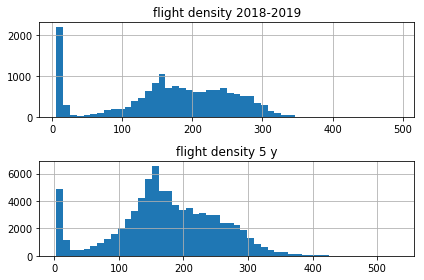

In [21]:
fig = plt.figure()

plt.subplot(2, 1, 1)
plt.title('flight density 2018-2019')
cbp_arrival_times['flightdensity'].hist(bins=50)
cbp_arrival_times['flightdensity'].mean()

plt.subplot(2, 1, 2)
plt.title('flight density 5 y')
cbp_arrival_times_5y['flightdensity'].hist(bins=50)
cbp_arrival_times_5y['flightdensity'].mean()

fig.tight_layout() # must be invoked before show, to avoid overlapping subplots
plt.show()

There are obvious ouliers on he left. <br>
The intention for checking flight densities here is to get an estimate of the total number of passengers who arrive at the airport, 
because although we have this information to train the model, we don't have it from the live landing schedule which we use as the input to the trained model when we make predictions later. 
Here we base our estimation simpl on the fact that that this figure changes mostly by month of the year (high season vs low season) and b the arrival terminal.  

In [24]:
avg_monthly_density = cbp_arrival_times.groupby('monthofyear').mean()['flightdensity']
avg_monthly_density = avg_monthly_density / avg_monthly_density.min()
avg_monthly_density

monthofyear
April        1.187390
August       1.236191
December     1.000000
February     1.055634
January      1.138858
July         1.236023
June         1.180202
March        1.034820
May          1.142991
November     1.029827
October      1.074053
September    1.125654
Name: flightdensity, dtype: float64

In [25]:
cbp_arrival_times.groupby(['terminal']).mean()['flightdensity']

terminal
satellite 2                           125.583717
satellite 5                             7.644068
satellite 7                           115.390465
terminal 4                            151.285584
tom bradley international terminal    223.693502
Name: flightdensity, dtype: float64

**Let's now look at the distribution of the wait times**


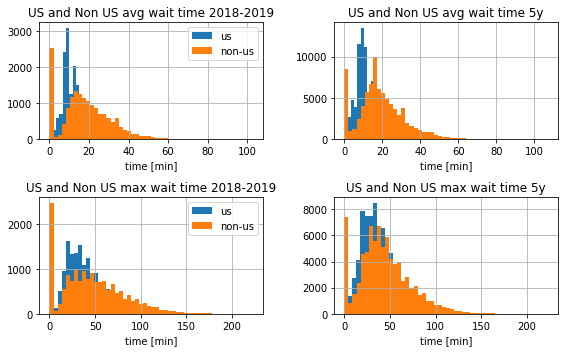

In [26]:
fig = plt.figure(figsize=(8, 5))

plt.subplot(2, 2, 1)
cbp_arrival_times['us_avg_wait_time'].hist(bins=50, label='us')
cbp_arrival_times['nus_avg_wait_time'].hist(bins=50, label='non-us')
plt.title('US and Non US avg wait time 2018-2019')
plt.xlabel('time [min]')
plt.legend()

plt.subplot(2, 2, 2)
cbp_arrival_times_5y['us_avg_wait_time'].hist(bins=50)
cbp_arrival_times_5y['nus_avg_wait_time'].hist(bins=50)
plt.title('US and Non US avg wait time 5y')
plt.xlabel('time [min]')

plt.subplot(2, 2, 3)
cbp_arrival_times['us_max_wait_time'].hist(bins=50, label='us')
cbp_arrival_times['nus_max_wait_time'].hist(bins=50, label='non-us')
plt.title('US and Non US max wait time 2018-2019')
plt.xlabel('time [min]')
plt.legend()

plt.subplot(2, 2, 4)
cbp_arrival_times_5y['us_max_wait_time'].hist(bins=50)
cbp_arrival_times_5y['nus_max_wait_time'].hist(bins=50)
plt.title('US and Non US max wait time 5y')
plt.xlabel('time [min]')

fig.tight_layout() # must be invoked before show, to avoid overlapping subplots
plt.show()

**There are outliers (0 wait time). We will remove them from the model later to improve accuracy.**

## Feature Selection

**Total number of passengers, month of the year, day of the week, hour of the day, and citizenship are candidates for independent variables in the model.** There are other features such as number of flights and number of booths. <br>
Let's look at their effects, distributions and correlations and choose the features to our model. sns joint plot is a good place to begin. I will not plot all of them here, only the booths and flights because as it turns out, they can be removed from the model.

Here is the scatter plot flights for avg wait time and for US and non US citizens. The correlation is not high, but it is interesting to note that there is a small correlation between flights and wait time for non US citizens.

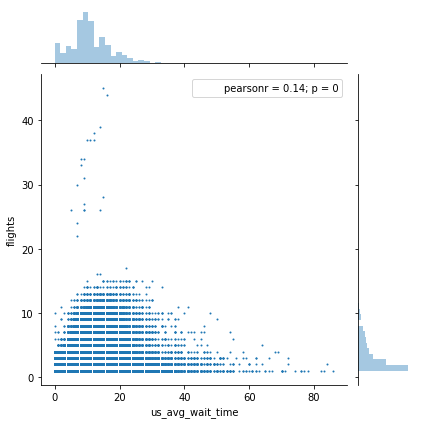

In [29]:
# 1y
sns.jointplot(x = 'us_avg_wait_time', y = 'flights',
              data = cbp_arrival_times_5y, s = 1)


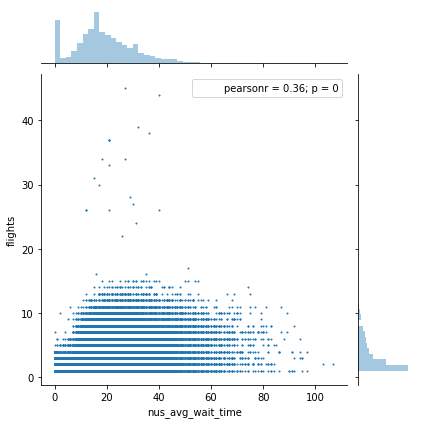

In [30]:
# 5 y
sns.jointplot(x = 'nus_avg_wait_time', y = 'flights',
              data = cbp_arrival_times_5y, s = 1)


As can be seen below, the number of booths is not correlated to the US citizens and slighl correlated o non US citizens.

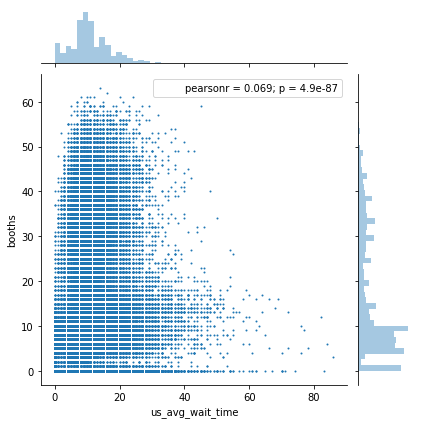

In [32]:
# 1y
sns.jointplot(x = 'us_avg_wait_time', y = 'booths',
              data = cbp_arrival_times_5y, s=1)

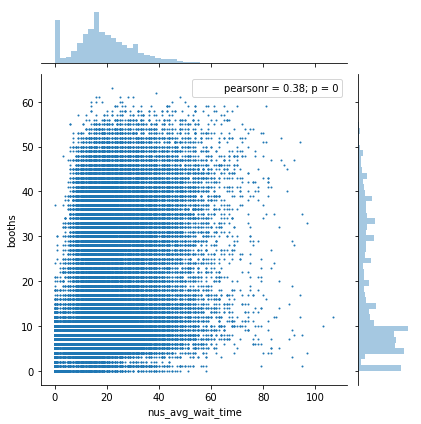

In [33]:
# 5y
sns.jointplot(x = 'nus_avg_wait_time', y = 'booths',
              data = cbp_arrival_times_5y, s=1)

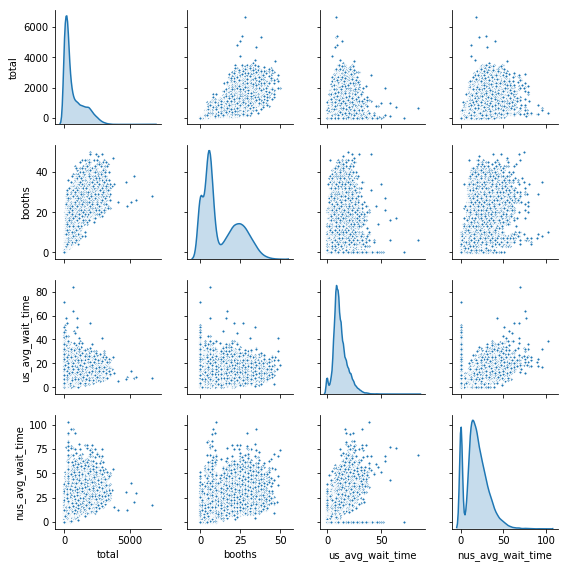

In [36]:
sns.pairplot(cbp_arrival_times[[u'total', u'booths', u'us_avg_wait_time', u'nus_avg_wait_time']],  
                 palette = 'seismic',size=2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10))

we will not consider boots and flitghs in he model. This will become more clear by lookng at the correlation map below and noting the fact 
that number of booths is increased by the airport officials whenever there are more flights, and more passengers traveling makes more flights, 
and we already have  total number of passengers as one of the features.

### Correlation map

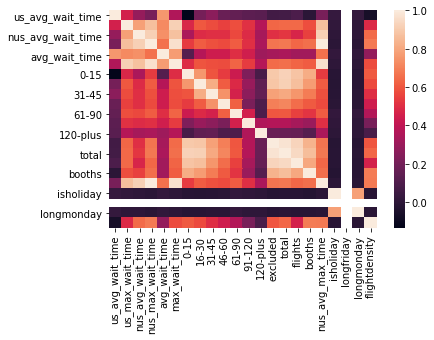

In [34]:
# 1y
sns.heatmap(cbp_arrival_times.corr())

Here is a more zoomed in version of the above for the features that we care.

<function matplotlib.pyplot.title(s, *args, **kwargs)>

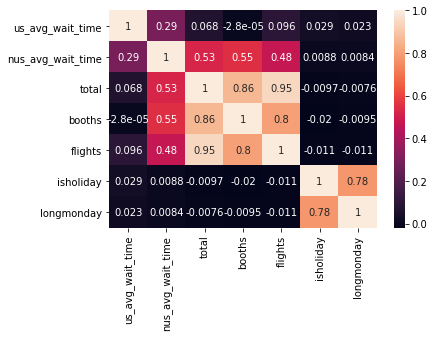

In [35]:
# 1y
sns.heatmap(cbp_arrival_times[['us_avg_wait_time', 'nus_avg_wait_time', 'hour', 
                               'dayofweek', 'monthofyear', 'total', 'booths', 
                               'flights', 'isholiday', 'longmonday']].corr(), annot= True)
plt.title

So the booths and flights (number of) are highly correlated with the total (number of passengers), we will drop them from the model. <br>
You can see that there are other features such as holiday and longmoday (Monday of a long weekend). I won' show it in this notebook, 
but during the experimentation with the model and plotting the feature importances, 
these features also turned out to be insignificant and droppend from the model.

**day of the week** does seem to have variation as seen below. We will include it in the model.

Text(0.5,1,'US avg wait time 2018 - 2019')

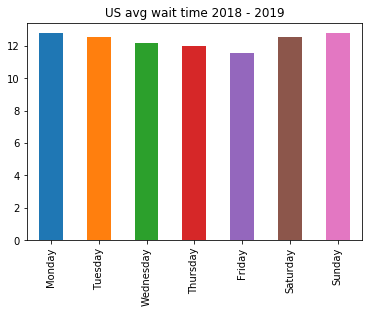

In [49]:
days = pd.Categorical(cbp_arrival_times.dayofweek, categories=day_names, ordered=True)
cbp_arrival_times.groupby([days]).mean()['us_avg_wait_time'].plot.bar() #.unstack(fill_value=0)
plt.title('US avg wait time 2018 - 2019')

Text(0.5,1,'non US avg wait time 2018 - 2019')

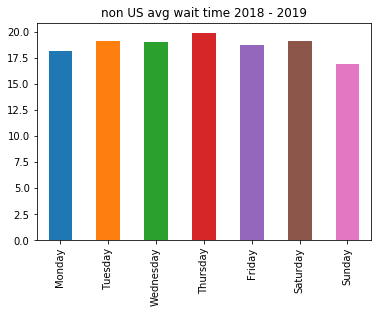

In [50]:
cbp_arrival_times.groupby([days]).mean()['nus_avg_wait_time'].plot.bar() #.unstack(fill_value=0)
plt.title('non US avg wait time 2018 - 2019')

**months of the year** does show significant amount of variation. We will inlcude them in the model. 

Text(0.5,1,'avg wit time 2018 - 2019')

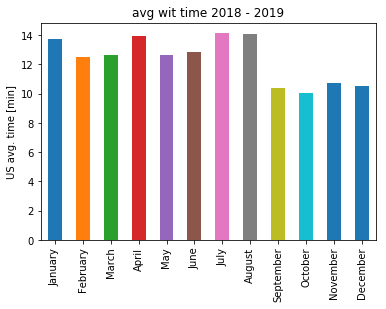

In [53]:
months = pd.Categorical(cbp_arrival_times.monthofyear, categories=month_names, ordered=True)
cbp_arrival_times.groupby([months]).mean()['us_avg_wait_time'].plot.bar()
plt.ylabel('US avg. time [min]')
plt.title('avg wit time 2018 - 2019')

Text(0.5,1,'avg wait time 2018 - 2019')

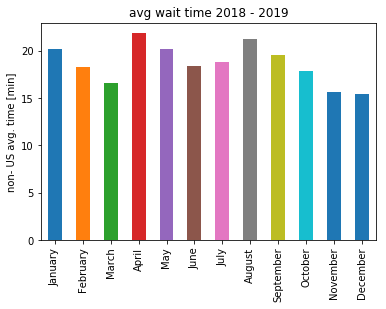

In [54]:
cbp_arrival_times.groupby([months]).mean()['nus_avg_wait_time'].plot.bar()
plt.ylabel('non- US avg. time [min]')
plt.title('avg wait time 2018 - 2019')

**holiday** seems to have a slight variation, but during the modeling I found them to be insignificant, so I dropped them from the model.

Text(0,0.5,'avg wait time')

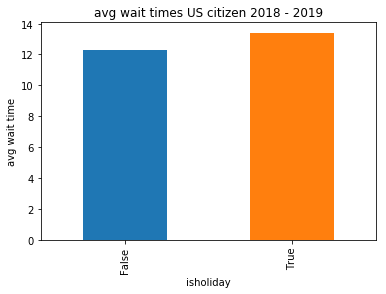

In [58]:
cbp_arrival_times.groupby(['isholiday']).mean()['us_avg_wait_time'].plot.bar(title='avg wait times US citizen 2018 - 2019')
plt.ylabel('avg wait time')

Text(0,0.5,'avg wait time')

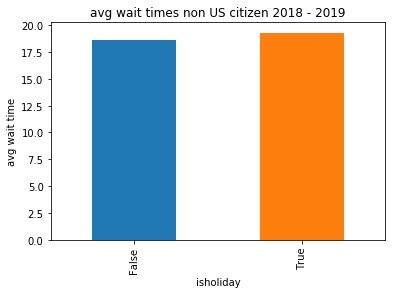

In [57]:
cbp_arrival_times.groupby(['isholiday']).mean()['nus_avg_wait_time'].plot.bar(title='avg wait times non US citizen 2018 - 2019')
plt.ylabel('avg wait time')

**long weekend** may intuitively seem important (long Monday shown below), 
but as seen below it is not that much and during the model selection I did not get a significant effect. So I dropped them.

Text(0.5,1,'US citizens 2018 - 2019')

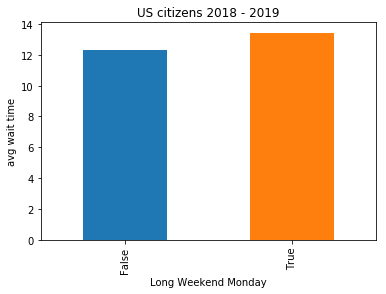

In [59]:
cbp_arrival_times.groupby(['longmonday']).mean()['us_avg_wait_time'].plot.bar()
plt.xlabel('Long Weekend Monday')
plt.ylabel('avg wait time')
plt.title('US citizens 2018 - 2019')

Text(0.5,1,'non US citizens 2018 - 2019')

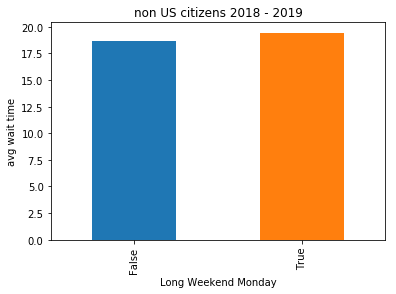

In [60]:
cbp_arrival_times.groupby(['longmonday']).mean()['nus_avg_wait_time'].plot.bar()
plt.xlabel('Long Weekend Monday')
plt.ylabel('avg wait time')
plt.title('non US citizens 2018 - 2019')

**arrival terminal** is indeed important, both intuitively and as seen below from the extent that it changes.

Text(0,0.5,'time [min]')

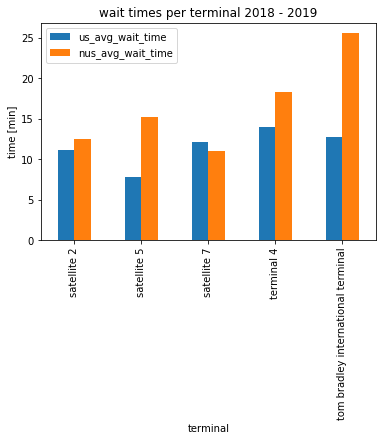

In [61]:
cbp_arrival_times.groupby(['terminal']).mean()[['us_avg_wait_time', 'nus_avg_wait_time']].plot.bar(
    title = 'wait times per terminal 2018 - 2019')
plt.legend()
plt.ylabel('time [min]')

# Modeling

We begin by making a dataframe withought outlisers and missing data.

In [37]:
# remove 0 entries for average times
cbp_clean = get_cleandf(cbp_arrival_times) # - > [(cbp_arrival_times['us_avg_wait_time'] > 0) & (cbp_arrival_times['nus_avg_wait_time'] > 0)]
print(cbp_arrival_times.shape)
print(cbp_clean.shape)

(16412, 28)
(10152, 28)


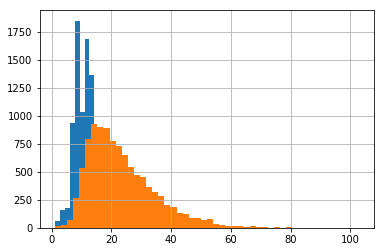

In [38]:
cbp_clean['us_avg_wait_time'].hist(bins=50)
cbp_clean['nus_avg_wait_time'].hist(bins=50)

In [152]:
# xg_regressor = xgboost.XGBRegressor(colsample_bytree=0.4,
#                  gamma=0,                 
#                  learning_rate=0.07,
#                  min_child_weight=1.5,
#                  n_estimators=2000,                                                                    
#                  reg_alpha=0.75,
#                  reg_lambda=0.45,
#                  subsample=0.6,
#                  seed=42) 

I assume that the flight schedules stay relatively unchanged from one year to the next year. This is actually reflected in the performance of the model as it generates acceptable results. The less than one year assupmtion for the consistency of the flight schedules is intuitively wrong, and when I trained the model on 4 years (train with with more data) the model performed poorly compared to training on 1 year. This means that an annual model is probably a good description of the reality.

**The following sections show the experimentation with different models. Linear regression is done to create a baseline and then random forest and XGBoost models are created for bettwe results. for the annual (1 year) model, which is the best model, I used 2017-2018 data to train, 50% random subset of 2018-2019 to validate and the other 50% to test.**

## Linear Regression
**train on 2017 - 2018, test on 2018 - 2019**

In [39]:
cbp_arrival_times_17_18 =  get_df(data_directory, ['LAX_Arrivals_2017_2018.csv'])
cbp_arrival_times_18_19 =  get_df(data_directory, ['LAX_Arrivals_2018_2019.csv'])

cbp_arrival_times_17_18 = transform_df(cbp_arrival_times_17_18)
cbp_arrival_times_18_19 = transform_df(cbp_arrival_times_18_19)

cbp_clean_17_18 = get_cleandf(cbp_arrival_times_17_18)
cbp_clean_18_19 = get_cleandf(cbp_arrival_times_18_19)

independent_variables=['terminal', 'hour', 'dayofweek', 'monthofyear', 'flights', 'total']

X_17_18, y_17_18 = get_xy(cbp_clean_17_18, independent_variables = independent_variables)
print('after get_xy 17 - 18', 'X.shape', X_17_18.shape, 'y.shape', y_17_18.shape)

X_18_19, y_18_19 = get_xy(cbp_clean_18_19, independent_variables = independent_variables)
print('after get_xy 18 - 19', 'X.shape', X_18_19.shape, 'y.shape', y_18_19.shape)

X_17_18 = labelencode(X_17_18, project_directory)
print('label 17 - 18 encoded X.shape', X_17_18.shape)

X_18_19 = labelencode(X_18_19, project_directory)
print('label 18 - 19 encoded X.shape', X_18_19.shape)



after get_xy 17 - 18 X.shape (20152, 7) y.shape (20152,)
after get_xy 18 - 19 X.shape (20304, 7) y.shape (20304,)
label 17 - 18 encoded X.shape (20152, 7)
label 18 - 19 encoded X.shape (20304, 7)


In [40]:
X_train, _, y_train, _ = train_test_split(X_17_18, y_17_18, test_size=0)
print('train', X_train.shape, y_train.shape)
# we need these 18_19 time data for validation
X_test, _, y_test, _ = train_test_split(X_18_19, y_18_19, test_size=0)
print('test', X_test.shape, y_test.shape)

train (20152, 7) (20152,)
test (20304, 7) (20304,)


In [42]:
# Let's see what a simple linear regression does
lin_regressor = LinearRegression()
lin_regressor.fit(X_train, y_train)
y_test_pred_linreg = lin_regressor.predict(X_test)

In [52]:
r2 = 'R2 score %s' % lin_regressor.score(X_test, y_test)
rmse = 'RMSE %s' % math.sqrt(mean_squared_error(y_test, y_test_pred_linreg))
print(bcolors.RED + r2 + bcolors.ENDC)
print(bcolors.RED + rmse + bcolors.ENDC, )

R2 score 0.3380215359103652
RMSE 8.420315291953413


**We will use these as baselines**

We can plot the predicted values agains the actuals to see to what extent the follow the variation.

In [53]:
yy_linreg = pd.DataFrame(columns = ['y_val', 'y_val_pred'], data = np.concatenate(
    (y_test.values.reshape(-1,1), y_test_pred_linreg.reshape(-1, 1)), axis = 1))

Text(0,0.5,'wait time [min]')

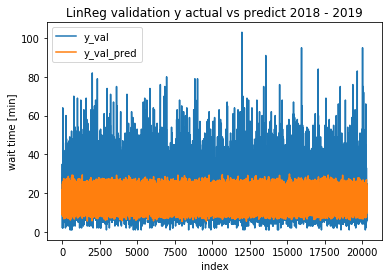

In [54]:
yy_linreg.plot.line()
plt.title('LinReg validation y actual vs predict 2018 - 2019')
plt.xlabel('index')
plt.ylabel('wait time [min]')

Text(0,0.5,'y pred [min]')

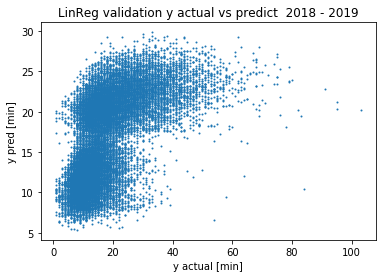

In [55]:
plt.scatter(yy_linreg['y_val'].values, yy_linreg['y_val_pred'].values, s=1)
plt.title('LinReg validation y actual vs predict  2018 - 2019')
plt.xlabel('y actual [min]')
plt.ylabel('y pred [min]')

We can see a correlation between y actual and y predicted, but there is certaily room for improvement.

Let's save this model.

In [146]:
with open(resource_directory + 'linreg.md', "wb") as output_file:
    pickle.dump(lin_regressor, output_file)

## Random Forest
I will just create a model with 1000 estimators and I leave the other parameters to default values. Random forest is easier than linear regression because we don't need to onehot encode the variables.

In [56]:
cbp_arrival_times_17_18 =  get_df(data_directory, ['LAX_Arrivals_2017_2018.csv'])
cbp_arrival_times_18_19 =  get_df(data_directory, ['LAX_Arrivals_2018_2019.csv'])

cbp_arrival_times_17_18 = transform_df(cbp_arrival_times_17_18)
cbp_arrival_times_18_19 = transform_df(cbp_arrival_times_18_19)

cbp_clean_17_18 = get_cleandf(cbp_arrival_times_17_18)
cbp_clean_18_19 = get_cleandf(cbp_arrival_times_18_19)

independent_variables=['terminal', 'hour', 'dayofweek', 'monthofyear', 'flights', 'total']

X_17_18, y_17_18 = get_xy(cbp_clean_17_18, independent_variables = independent_variables)
print('after get_xy 17 - 18', 'X.shape', X_17_18.shape, 'y.shape', y_17_18.shape)

X_18_19, y_18_19 = get_xy(cbp_clean_18_19, independent_variables = independent_variables)
print('after get_xy 18 - 19', 'X.shape', X_18_19.shape, 'y.shape', y_18_19.shape)

X_17_18 = labelencode(X_17_18, project_directory)
print('label 17 - 18 encoded X.shape', X_17_18.shape)

X_18_19 = labelencode(X_18_19, project_directory)
print('label 18 - 19 encoded X.shape', X_18_19.shape)

after get_xy 17 - 18 X.shape (20152, 7) y.shape (20152,)
after get_xy 18 - 19 X.shape (20304, 7) y.shape (20304,)
label 17 - 18 encoded X.shape (20152, 7)
label 18 - 19 encoded X.shape (20304, 7)


In [57]:
X_train, _, y_train, _ = train_test_split(X_17_18, y_17_18, test_size=0)
print('train', X_train.shape, y_train.shape)
# we need these 18_19 time data for validation
X_test, _, y_test, _ = train_test_split(X_18_19, y_18_19, test_size=0)
print('test', X_test.shape, y_test.shape)

train (20152, 7) (20152,)
test (20304, 7) (20304,)


In [58]:
randf_regressor = RandomForestRegressor(n_estimators = 1000, random_state = 42) 
randf_regressor.fit(X_train, y_train)   

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [59]:
y_test_pred_randf = randf_regressor.predict(X_test)

In [60]:
r2 = 'R2 score %s' % randf_regressor.score(X_test, y_test)
rmse = 'RMSE %s' % np.sqrt(mean_squared_error(y_test, y_test_pred_randf))
print(bcolors.RED + r2 + bcolors.ENDC)
print(bcolors.RED + rmse + bcolors.ENDC, )

R2 score 0.34432742961656304
RMSE 8.380114083253337


Slight improvement from linear regression. Let's get feature importances.

In [61]:
feature_importances = pd.DataFrame(randf_regressor.feature_importances_, 
                                   index = ['terminal', 'hour', 'dayofweek', 'monthofyear', 'flights', 'total', 'US'], 
                                   columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
total,0.317500
US,0.264466
hour,0.130546
monthofyear,0.115087
dayofweek,0.086672
flights,0.056662
terminal,0.029066


In [62]:
yy_randf = pd.DataFrame(columns = ['y_test', 'y_test_pred'], data = np.concatenate(
    (y_test.values.reshape(-1,1), y_test_pred_randf.reshape(-1, 1)), axis = 1))

Text(0,0.5,'wait time [min]')

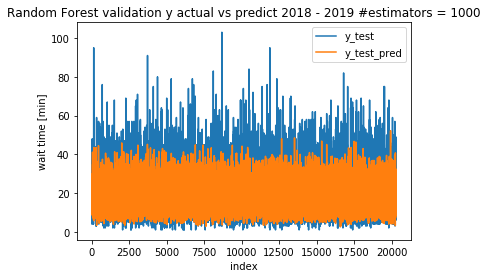

In [63]:
yy_randf.plot.line()
plt.title('Random Forest validation y actual vs predict 2018 - 2019 #estimators = 1000')
plt.xlabel('index')
plt.ylabel('wait time [min]')

Text(0,0.5,'y predict [min]')

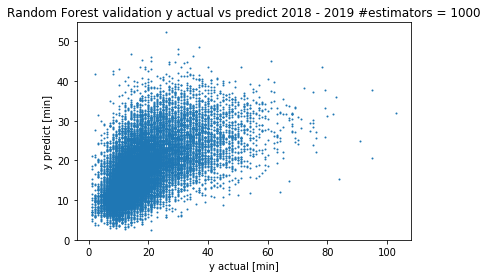

In [64]:
plt.scatter(yy_randf['y_test'].values, yy_randf['y_test_pred'].values, s=1)
plt.title('Random Forest validation y actual vs predict 2018 - 2019 #estimators = 1000')
plt.xlabel('y actual [min]')
plt.ylabel('y predict [min]')

The correlation seems a bit better than linear regression. We can save this and move on.

In [177]:
with open(resource_directory + 'randf.md', "wb") as output_file:
    pickle.dump(randf_regressor, output_file)

## XG boost
I did not split 2018-2019 data to validation and test in the previous models, because they did not perform very well and I am not going to choose them, so it was not worth spending the time. Here I do because this is the model I am going to choose and hyper tune.

In [279]:
cbp_arrival_times_17_18 =  get_df(data_directory, ['LAX_Arrivals_2017_2018.csv'])
cbp_arrival_times_18_19 =  get_df(data_directory, ['LAX_Arrivals_2018_2019.csv'])

cbp_arrival_times_17_18 = transform_df(cbp_arrival_times_17_18)
cbp_arrival_times_18_19 = transform_df(cbp_arrival_times_18_19)

cbp_clean_17_18 = get_cleandf(cbp_arrival_times_17_18)
cbp_clean_18_19 = get_cleandf(cbp_arrival_times_18_19)

Let's split 2018 - 2019 data to validation and test sets, half each.

In [280]:
test_size = len(cbp_clean_18_19) // 2

In [281]:
cbp_clean_17_18 = cbp_clean_17_18.sample(frac=1).reset_index(drop=True)
cbp_clean_18_19 = cbp_clean_18_19.sample(frac=1).reset_index(drop=True)

In [282]:
cbp_clean_18_19_val = cbp_clean_18_19.ix[:test_size-1]
cbp_clean_18_19_test = cbp_clean_18_19.ix[test_size:]

In [283]:
print(cbp_clean_18_19.shape)
print(cbp_clean_18_19_val.shape)
print(cbp_clean_18_19_test.shape)

(10152, 28)
(5076, 28)
(5076, 28)


In [284]:
independent_variables=['terminal', 'hour', 'dayofweek', 'monthofyear', 'flights', 'total']

X_17_18_train, y_17_18_train = get_xy(cbp_clean_17_18, independent_variables = independent_variables)
print('after get_xy 17 - 18', 'X.shape', X_17_18_train.shape, 'y.shape', y_17_18_train.shape)

X_18_19_val, y_18_19_val = get_xy(cbp_clean_18_19_val, independent_variables = independent_variables)
print('after get_xy 18 - 19', 'X.shape', X_18_19_val.shape, 'y.shape', y_18_19_val.shape)

X_18_19_test, y_18_19_test = get_xy(cbp_clean_18_19_test, independent_variables = independent_variables)
print('after get_xy 18 - 19', 'X.shape', X_18_19_test.shape, 'y.shape', y_18_19_test.shape)

after get_xy 17 - 18 X.shape (20152, 7) y.shape (20152,)
after get_xy 18 - 19 X.shape (10152, 7) y.shape (10152,)
after get_xy 18 - 19 X.shape (10152, 7) y.shape (10152,)


In [285]:
X_17_18_train = labelencode(X_17_18_train, project_directory, save=False)
print('label 17 - 18 encoded X.shape', X_17_18_train.shape)

X_18_19_val = labelencode(X_18_19_val, project_directory, save=False)
print('label 18 - 19 encoded X.shape', X_18_19_val.shape)

X_18_19_test = labelencode(X_18_19_test, project_directory, save=False)
print('label 18 - 19 encoded X.shape', X_18_19_test.shape)

label 17 - 18 encoded X.shape (20152, 7)
label 18 - 19 encoded X.shape (10152, 7)
label 18 - 19 encoded X.shape (10152, 7)


In [286]:
X_train, _, y_train, _ = train_test_split(X_17_18_train, y_17_18_train, test_size=0)
print('train', X_train.shape, y_train.shape)

# we need these 18_19 time data for validation
X_val, _, y_val, _ = train_test_split(X_18_19_val, y_18_19_val, test_size=0)
print('val', X_val.shape, y_val.shape)

X_test, _, y_test, _ = train_test_split(X_18_19_test, y_18_19_test, test_size=0)
print('test', X_test.shape, y_test.shape)

train (20152, 7) (20152,)
val (10152, 7) (10152,)
test (10152, 7) (10152,)


In [287]:
xg_regressor = xgboost.XGBRegressor(colsample_bytree=0.8,
                 gamma=0,                 
                 learning_rate=0.01,
                 min_child_weight=1.5,
                 n_estimators=5000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=1,
                 max_depth=2,
                 seed=42) 

xg_regressor.fit(X_train.values, y_train.values)  

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=2, min_child_weight=1.5, missing=None, n_estimators=5000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
       silent=True, subsample=1)

In [288]:
y_train_pred_xg = xg_regressor.predict(X_train.values)
y_test_pred_xg = xg_regressor.predict(X_test.values)

In [289]:
trainr2 = 'R2 score %s' % xg_regressor.score(X_train.values, y_train.values)
trainrmse = 'RMSE %s' % math.sqrt(mean_squared_error(y_train.values, y_train_pred_xg))
testr2 = 'R2 score %s' % xg_regressor.score(X_test.values, y_test.values)
testrmse = 'RMSE %s' % math.sqrt(mean_squared_error(y_test.values, y_test_pred_xg))

print(bcolors.RED + trainr2 + bcolors.ENDC)
print(bcolors.RED + trainrmse + bcolors.ENDC)
print(bcolors.RED + testr2 + bcolors.ENDC)
print(bcolors.RED + testrmse + bcolors.ENDC)

R2 score 0.4586156931295504
RMSE 6.980812183964327
R2 score 0.4047673478137971
RMSE 8.014208011368545


We are doing better than random forest and linear regression, but there is small overfitting we need to resolve here.

In [290]:
yy_test_xg = pd.DataFrame(columns = ['y_test', 'y_test_pred'], data = np.concatenate(
    (y_test.values.reshape(-1,1), y_test_pred_xg.reshape(-1, 1)), axis = 1))

Text(0,0.5,'wait time [min]')

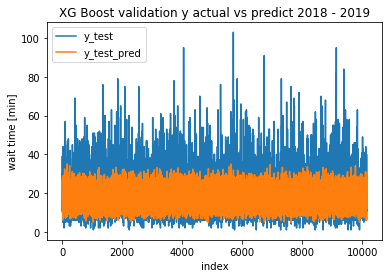

In [291]:
yy_test_xg.plot.line()
plt.title('XG Boost validation y actual vs predict 2018 - 2019')
plt.xlabel('index')
plt.ylabel('wait time [min]')

Text(0,0.5,'y predict [min]')

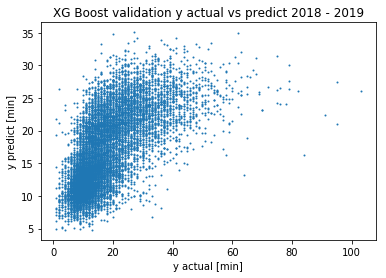

In [292]:
plt.scatter(yy_test_xg['y_test'].values, yy_test_xg['y_test_pred'].values, s=1)
plt.title('XG Boost validation y actual vs predict 2018 - 2019')
plt.xlabel('y actual [min]')
plt.ylabel('y predict [min]')

If we plot the histograms of the actuals and predicted values, we see that the predicted values have a bimodal distribution. 
This might be OK, or might be an issues because I stacked US and non US citizens to make the dataset (looks like that's how the two modes are separated). If we plot the actual grouped by the US and non US citizens, we see that they have a mode that corresponds to the bimodal predicted values.
This may need further investigation, but I leave it here and continue with improving the model.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000205B7DF5860>,
      dtype=object)

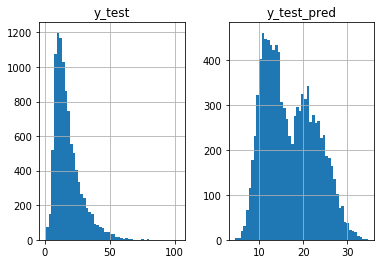

In [156]:
yy_test_xg.hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000205B648E438>,
      dtype=object)

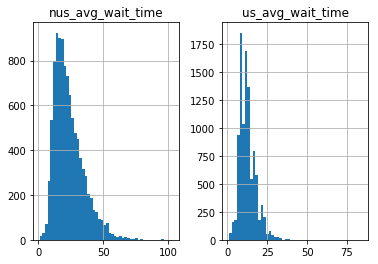

In [157]:
cbp_clean_18_19[['us_avg_wait_time', 'nus_avg_wait_time']].hist(bins=50)

Time to save the model.

In [176]:
with open(resource_directory + 'xg.md', "wb") as output_file:
    pickle.dump(xg_regressor, output_file)

## Grid Search
As we saw above, the XGBoost model showed some overfitting. I am going to overcome that issue by doing some parameter tuning here. I will do it by a grid search.

In [58]:
cbp_arrival_times_17_18 =  get_df(data_directory, ['LAX_Arrivals_2017_2018.csv'])
cbp_arrival_times_18_19 =  get_df(data_directory, ['LAX_Arrivals_2018_2019.csv'])

cbp_arrival_times_17_18 = transform_df(cbp_arrival_times_17_18)
cbp_arrival_times_18_19 = transform_df(cbp_arrival_times_18_19)

cbp_clean_17_18 = get_cleandf(cbp_arrival_times_17_18)
cbp_clean_18_19 = get_cleandf(cbp_arrival_times_18_19)

In [59]:
test_size = len(cbp_clean_18_19) // 2

In [60]:
cbp_clean_17_18 = cbp_clean_17_18.sample(frac=1).reset_index(drop=True)
cbp_clean_18_19 = cbp_clean_18_19.sample(frac=1).reset_index(drop=True)

In [61]:
cbp_clean_18_19_val = cbp_clean_18_19.ix[:test_size-1]
cbp_clean_18_19_test = cbp_clean_18_19.ix[test_size:]

In [62]:
print(cbp_clean_18_19.shape)
print(cbp_clean_18_19_val.shape)
print(cbp_clean_18_19_test.shape)

(10152, 28)
(5076, 28)
(5076, 28)


In [63]:
independent_variables=['terminal', 'hour', 'dayofweek', 'monthofyear', 'flights', 'total']

X_17_18_train, y_17_18_train = get_xy(cbp_clean_17_18, independent_variables = independent_variables)
print('after get_xy 17 - 18', 'X.shape', X_17_18_train.shape, 'y.shape', y_17_18_train.shape)

X_18_19_val, y_18_19_val = get_xy(cbp_clean_18_19_val, independent_variables = independent_variables)
print('after get_xy 18 - 19', 'X.shape', X_18_19_val.shape, 'y.shape', y_18_19_val.shape)

X_18_19_test, y_18_19_test = get_xy(cbp_clean_18_19_test, independent_variables = independent_variables)
print('after get_xy 18 - 19', 'X.shape', X_18_19_test.shape, 'y.shape', y_18_19_test.shape)

after get_xy 17 - 18 X.shape (20152, 7) y.shape (20152,)
after get_xy 18 - 19 X.shape (10152, 7) y.shape (10152,)
after get_xy 18 - 19 X.shape (10152, 7) y.shape (10152,)


In [64]:
X_17_18_train = labelencode(X_17_18_train, project_directory, save=False)
print('label 17 - 18 encoded X.shape', X_17_18_train.shape)

X_18_19_val = labelencode(X_18_19_val, project_directory, save=False)
print('label 18 - 19 encoded X.shape', X_18_19_val.shape)

X_18_19_test = labelencode(X_18_19_test, project_directory, save=False)
print('label 18 - 19 encoded X.shape', X_18_19_test.shape)

label 17 - 18 encoded X.shape (20152, 7)
label 18 - 19 encoded X.shape (10152, 7)
label 18 - 19 encoded X.shape (10152, 7)


In [65]:
X_train, _, y_train, _ = train_test_split(X_17_18_train, y_17_18_train, test_size=0)
print('train', X_train.shape, y_train.shape)

# we need these 18_19 time data for validation
X_val, _, y_val, _ = train_test_split(X_18_19_val, y_18_19_val, test_size=0)
print('val', X_val.shape, y_val.shape)

X_test, _, y_test, _ = train_test_split(X_18_19_test, y_18_19_test, test_size=0)
print('test', X_test.shape, y_test.shape)

train (20152, 7) (20152,)
test (10152, 7) (10152,)
test (10152, 7) (10152,)


**Parameter grid**

In [66]:
colsample_bytrees = [0.8, 1]
gammas = [0, 1, 5]
learning_rates = [0.01, .06, 0.1]
# min_child_weights = [1, 1.5, 2, 5]
n_estimators = [500, 1000, 1500, 5000]
# reg_alphas = [0.5, 0.75, 1.0]
# reg_lambdas = [1, 3, 5]
subsamples = [0.8, 1]
max_depths = [2, 3, 4]

In [67]:
# creates a new xgb model for given parameters
def get_xg_model(**keywargs):
    xg_regressor = xgboost.XGBRegressor(
                 colsample_bytree = keywargs['colsample_bytree'],
                 gamma=keywargs['gamma'],                 
                 learning_rate=keywargs['learning_rate'],
                 # min_child_weight=keywargs['min_child_weight'],
                 n_estimators=keywargs['n_estimators'],                                                                    
                 # reg_alpha=keywargs['reg_alpha'],
                 # reg_lambda=keywargs['reg_lambda'],
                 subsample=keywargs['subsample'],
                 max_depth=keywargs['max_depth'],
                 seed=42) 
    return xg_regressor

In [68]:
# the following variables are used to store the scores returned by the grid search.
r2_train, rms_train, r2_val, rms_val = [], [], [], []

**Let's perform the grid search**

In [69]:
for colsample_bytree in colsample_bytrees:
    params = {}
    params['colsample_bytree'] = colsample_bytree 
    for gamma in gammas:
        params['gamma'] = gamma
        for learning_rate in learning_rates:
            params['learning_rate'] = learning_rate
            for n_estimator in n_estimators:
                params['n_estimators'] = n_estimator
                for subsample in subsamples:
                    params['subsample'] = subsample
                    for max_depth in max_depths:
                        params['max_depth'] = max_depth
                        print('training model with ', params)
                        regressor =  get_xg_model(colsample_bytree = colsample_bytree,
                                                  gamma = gamma,
                                                  learning_rate = learning_rate,
                                                  n_estimators = n_estimator,
                                                  subsample = subsample,
                                                  max_depth = max_depth)
                        regressor.fit(X_train.values, y_train.values)
                        y_train_pred_xg = regressor.predict(X_train.values)
                        y_val_pred_xg = regressor.predict(X_val.values)
                        
                        score = regressor.score(X_train.values, y_train.values)
                        rms = math.sqrt(mean_squared_error(y_train.values, y_train_pred_xg))
                        r2_train.append(score)
                        rms_train.append(rms)
                        print('train R2', score, 'train rms', rms)
                        score = regressor.score(X_val.values, y_val.values)
                        rms = math.sqrt(mean_squared_error(y_val.values, y_val_pred_xg))
                        r2_val.append(score)
                        rms_val.append(rms)
                        print('val R2', score, 'val rms', rms)

training model with  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 100, 'subsample': 0.8, 'max_depth': 2}
train R2 -0.14526062502741777 train rms 10.153254845934976
val R2 -0.24479785398063214 val rms 11.589553657066821
training model with  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 100, 'subsample': 0.8, 'max_depth': 3}
train R2 -0.12097149698943044 train rms 10.045010781910726
val R2 -0.23580729202785533 val rms 11.547624992700333
training model with  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 100, 'subsample': 0.8, 'max_depth': 4}
train R2 -0.10022111246910859 train rms 9.951604539502798
val R2 -0.21907520953218018 val rms 11.469184653826145
training model with  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'n_estimators': 100, 'subsample': 1, 'max_depth': 2}
train R2 -0.13777965274076753 train rms 10.120039409249344
val R2 -0.2359297776711229 val rms 11.548197243422264


train R2 0.4425330293442461 train rms 7.0837413083692455
val R2 0.38855076185601645 val rms 8.122645492490365
training model with  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.06, 'n_estimators': 500, 'subsample': 1, 'max_depth': 3}
train R2 0.49814532666302896 train rms 6.721127106668999
val R2 0.3050315672477055 val rms 8.659639927251927
training model with  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.06, 'n_estimators': 500, 'subsample': 1, 'max_depth': 4}
train R2 0.5503743863648686 train rms 6.361779964657391
val R2 0.2714738893166415 val rms 8.866247612051998
training model with  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.06, 'n_estimators': 1000, 'subsample': 0.8, 'max_depth': 2}
train R2 0.4699460853934221 train rms 6.9073767655468865
val R2 0.22621173368401237 val rms 9.13752051367058
training model with  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.06, 'n_estimators': 1000, 'subsample': 0.8, 'max_depth': 3}
train R2 0.5374252

train R2 0.694399938665135 train rms 5.2448109768029285
val R2 0.0023901355161293214 val rms 10.375228314800264
training model with  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'max_depth': 4}
train R2 0.819632796019707 train rms 4.029321384965232
val R2 0.022740220930732802 val rms 10.268861762842137
training model with  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 1, 'max_depth': 2}
train R2 0.5496663628618861 train rms 6.366786927976018
val R2 -0.3585601055449865 val rms 12.107562614447877
training model with  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 1, 'max_depth': 3}
train R2 0.6918415603569535 train rms 5.266719094813481
val R2 -0.2795871072033054 val rms 11.750388419745876
training model with  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 1, 'max_depth': 4}
train R2 0.81063

train R2 0.46205593370255016 train rms 6.9585969601765205
val R2 0.3932336671900064 val rms 8.091481262210804
training model with  {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.06, 'n_estimators': 500, 'subsample': 0.8, 'max_depth': 2}
train R2 0.44741584285204516 train rms 7.052650084277142
val R2 0.3768870555086534 val rms 8.199751325824877
training model with  {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.06, 'n_estimators': 500, 'subsample': 0.8, 'max_depth': 3}
train R2 0.501271437697571 train rms 6.700161065092612
val R2 0.33991491989476574 val rms 8.439510411722202
training model with  {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.06, 'n_estimators': 500, 'subsample': 0.8, 'max_depth': 4}
train R2 0.5578878250052857 train rms 6.308401984360843
val R2 0.2626120957737563 val rms 8.92000914709311
training model with  {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.06, 'n_estimators': 500, 'subsample': 1, 'max_depth': 2}
train R2 0.442533029

train R2 0.4822372412057561 train rms 6.82682117860062
val R2 0.20589177332324482 val rms 9.256720327736211
training model with  {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'n_estimators': 1000, 'subsample': 1, 'max_depth': 3}
train R2 0.5644249817490714 train rms 6.261589665590939
val R2 0.02625868783701657 val rms 10.250359400226703
training model with  {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'n_estimators': 1000, 'subsample': 1, 'max_depth': 4}
train R2 0.6449679436783681 train rms 5.653103101569501
val R2 0.022507412341994937 val rms 10.270084844413015
training model with  {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'max_depth': 2}
train R2 0.5581410372667767 train rms 6.306595210419033
val R2 -0.07840056674018525 val rms 10.787165671349632
training model with  {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'n_estimators': 5000, 'subsample': 0.8, 'max_depth': 3}
train R2 0.69480

train R2 0.4289439419691759 train rms 7.169559839035453
val R2 0.3859061818999737 val rms 8.140192172864387
training model with  {'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.06, 'n_estimators': 100, 'subsample': 0.8, 'max_depth': 4}
train R2 0.4664132726111872 train rms 6.930357393124732
val R2 0.39922578096576333 val rms 8.051428467668645
training model with  {'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.06, 'n_estimators': 100, 'subsample': 1, 'max_depth': 2}
train R2 0.3875803210826695 train rms 7.4246791537514785
val R2 0.36351849964088756 val rms 8.287245178306913
training model with  {'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.06, 'n_estimators': 100, 'subsample': 1, 'max_depth': 3}
train R2 0.4258542613231655 train rms 7.188929013083389
val R2 0.38038676568084995 val rms 8.1766919746123
training model with  {'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.06, 'n_estimators': 100, 'subsample': 1, 'max_depth': 4}
train R2 0.4620559337025

train R2 0.5858386519449514 train rms 6.105734351416213
val R2 0.11510246083945985 val rms 9.77155742765538
training model with  {'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.1, 'n_estimators': 1000, 'subsample': 0.8, 'max_depth': 2}
train R2 0.4888275470650577 train rms 6.7832346875289415
val R2 0.23119265850982762 val rms 9.108063629624125
training model with  {'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.1, 'n_estimators': 1000, 'subsample': 0.8, 'max_depth': 3}
train R2 0.5676611082940282 train rms 6.23828590281725
val R2 0.10805059755968838 val rms 9.810415569247255
training model with  {'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.1, 'n_estimators': 1000, 'subsample': 0.8, 'max_depth': 4}
train R2 0.6550249316837082 train rms 5.572460220946782
val R2 0.12908575230096098 val rms 9.694044137699416
training model with  {'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.1, 'n_estimators': 1000, 'subsample': 1, 'max_depth': 2}
train R2 0.48223295

KeyboardInterrupt: 

**based on the above grid search, we choose the following values for the final XGBoost model** <br>
gamma=0, 
learning_rate=0.01,
min_child_weight=1.5,
n_estimators=1500, 
subsample=1,
max_depth=2

## Tuned XGBoost model
We are now going to run the final XGboost model with the parameters we found from the grid search.

In [293]:
cbp_arrival_times_17_18 =  get_df(data_directory, ['LAX_Arrivals_2017_2018.csv'])
cbp_arrival_times_18_19 =  get_df(data_directory, ['LAX_Arrivals_2018_2019.csv'])

cbp_arrival_times_17_18 = transform_df(cbp_arrival_times_17_18)
cbp_arrival_times_18_19 = transform_df(cbp_arrival_times_18_19)

cbp_clean_17_18 = get_cleandf(cbp_arrival_times_17_18)
cbp_clean_18_19 = get_cleandf(cbp_arrival_times_18_19)

Let's split 2018 - 2019 data to validation and test sets, half each.

In [294]:
test_size = len(cbp_clean_18_19) // 2

In [295]:
cbp_clean_17_18 = cbp_clean_17_18.sample(frac=1).reset_index(drop=True)
cbp_clean_18_19 = cbp_clean_18_19.sample(frac=1).reset_index(drop=True)

In [296]:
cbp_clean_18_19_val = cbp_clean_18_19.ix[:test_size-1]
cbp_clean_18_19_test = cbp_clean_18_19.ix[test_size:]

In [297]:
print(cbp_clean_18_19.shape)
print(cbp_clean_18_19_val.shape)
print(cbp_clean_18_19_test.shape)

(10152, 28)
(5076, 28)
(5076, 28)


In [298]:
independent_variables=['terminal', 'hour', 'dayofweek', 'monthofyear', 'flights', 'total']

X_17_18_train, y_17_18_train = get_xy(cbp_clean_17_18, independent_variables = independent_variables)
print('after get_xy 17 - 18', 'X.shape', X_17_18_train.shape, 'y.shape', y_17_18_train.shape)

X_18_19_val, y_18_19_val = get_xy(cbp_clean_18_19_val, independent_variables = independent_variables)
print('after get_xy 18 - 19', 'X.shape', X_18_19_val.shape, 'y.shape', y_18_19_val.shape)

X_18_19_test, y_18_19_test = get_xy(cbp_clean_18_19_test, independent_variables = independent_variables)
print('after get_xy 18 - 19', 'X.shape', X_18_19_test.shape, 'y.shape', y_18_19_test.shape)

after get_xy 17 - 18 X.shape (20152, 7) y.shape (20152,)
after get_xy 18 - 19 X.shape (10152, 7) y.shape (10152,)
after get_xy 18 - 19 X.shape (10152, 7) y.shape (10152,)


In [299]:
X_17_18_train = labelencode(X_17_18_train, project_directory, save=False)
print('label 17 - 18 encoded X.shape', X_17_18_train.shape)

X_18_19_val = labelencode(X_18_19_val, project_directory, save=False)
print('label 18 - 19 encoded X.shape', X_18_19_val.shape)

X_18_19_test = labelencode(X_18_19_test, project_directory, save=False)
print('label 18 - 19 encoded X.shape', X_18_19_test.shape)

label 17 - 18 encoded X.shape (20152, 7)
label 18 - 19 encoded X.shape (10152, 7)
label 18 - 19 encoded X.shape (10152, 7)


In [300]:
X_train, _, y_train, _ = train_test_split(X_17_18_train, y_17_18_train, test_size=0)
print('train', X_train.shape, y_train.shape)

# we need these 18_19 time data for validation
X_val, _, y_val, _ = train_test_split(X_18_19_val, y_18_19_val, test_size=0)
print('val', X_val.shape, y_val.shape)

X_test, _, y_test, _ = train_test_split(X_18_19_test, y_18_19_test, test_size=0)
print('test', X_test.shape, y_test.shape)

train (20152, 7) (20152,)
val (10152, 7) (10152,)
test (10152, 7) (10152,)


In [301]:
xg_regressor = xgboost.XGBRegressor(colsample_bytree=0.8,
                 gamma=0,                 
                 learning_rate=0.01,
                 min_child_weight=1.5,
                 n_estimators=1500,                                                                    
                 #reg_alpha=0.75,
                 # reg_lambda=0.8,
                 subsample=1,
                 max_depth=2,
                 seed=42) 

xg_regressor.fit(X_train.values, y_train.values)  

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=2, min_child_weight=1.5, missing=None, n_estimators=1500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [302]:
y_train_pred_xg = xg_regressor.predict(X_train.values)
y_test_pred_xg = xg_regressor.predict(X_test.values)

In [303]:
trainr2 = 'R2 score %s' % xg_regressor.score(X_train.values, y_train.values)
trainrmse = 'RMSE %s' % math.sqrt(mean_squared_error(y_train.values, y_train_pred_xg))
testr2 = 'R2 score %s' % xg_regressor.score(X_test.values, y_test.values)
testrmse = 'RMSE %s' % math.sqrt(mean_squared_error(y_test.values, y_test_pred_xg))

print(bcolors.RED + trainr2 + bcolors.ENDC)
print(bcolors.RED + trainrmse + bcolors.ENDC)
print(bcolors.RED + testr2 + bcolors.ENDC)
print(bcolors.RED + testrmse + bcolors.ENDC)

R2 score 0.4186265376730872
RMSE 7.234036974915807
R2 score 0.39633575002535637
RMSE 8.081695861515502


We have much less overfitting now. As beofre, we plot actuals vs predicted to see how they match visually.

In [304]:
yy_test_xg = pd.DataFrame(columns = ['y_test', 'y_test_pred'], data = np.concatenate(
    (y_test.values.reshape(-1,1), y_test_pred_xg.reshape(-1, 1)), axis = 1))

Text(0,0.5,'wait time [min]')

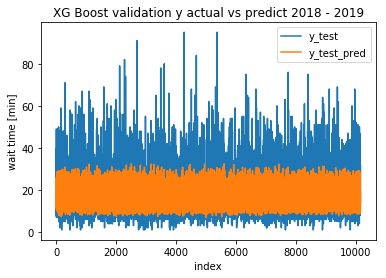

In [305]:
yy_test_xg.plot.line()
plt.title('XG Boost validation y actual vs predict 2018 - 2019')
plt.xlabel('index')
plt.ylabel('wait time [min]')

Text(0,0.5,'y predict [min]')

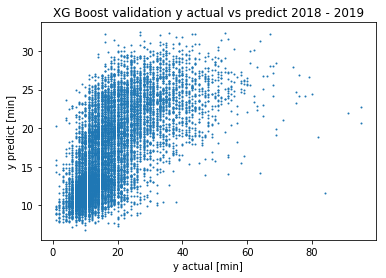

In [306]:
plt.scatter(yy_test_xg['y_test'].values, yy_test_xg['y_test_pred'].values, s=1)
plt.title('XG Boost validation y actual vs predict 2018 - 2019')
plt.xlabel('y actual [min]')
plt.ylabel('y predict [min]')

In [307]:
print(yy_test_xg['y_test'].mean())
print(yy_test_xg['y_test_pred'].mean())

18.02876280535855
17.04012835110333


# Appendix
As I mentioned earlier, the best model is based on the assumption that the flight schedules remain relatively fixed from one year to another, and training the model otherwise produces worse results. I also mentioned that holidays and other features won't improve the model. The following modeling experiments verify these etatements. I do not comment the following steps much as they are very similar to the ones mentioned before. 

## Train with more features
We are going to see whether including long weekends improves our model.

In [308]:
cbp_arrival_times_17_18 =  get_df(data_directory, ['LAX_Arrivals_2017_2018.csv'])
cbp_arrival_times_18_19 =  get_df(data_directory, ['LAX_Arrivals_2018_2019.csv'])

cbp_arrival_times_17_18 = transform_df(cbp_arrival_times_17_18)
cbp_arrival_times_18_19 = transform_df(cbp_arrival_times_18_19)

cbp_clean_17_18 = get_cleandf(cbp_arrival_times_17_18)
cbp_clean_18_19 = get_cleandf(cbp_arrival_times_18_19)

Let's split 2018 - 2019 data to validation and test sets, half each.

In [309]:
test_size = len(cbp_clean_18_19) // 2

In [310]:
cbp_clean_17_18 = cbp_clean_17_18.sample(frac=1).reset_index(drop=True)
cbp_clean_18_19 = cbp_clean_18_19.sample(frac=1).reset_index(drop=True)

In [311]:
cbp_clean_18_19_val = cbp_clean_18_19.ix[:test_size-1]
cbp_clean_18_19_test = cbp_clean_18_19.ix[test_size:]

In [312]:
print(cbp_clean_18_19.shape)
print(cbp_clean_18_19_val.shape)
print(cbp_clean_18_19_test.shape)

(10152, 28)
(5076, 28)
(5076, 28)


In [313]:
independent_variables=['terminal', 'hour', 'dayofweek', 'monthofyear', 'flights', 'total', 'longfriday', 'longmonday']

X_17_18_train, y_17_18_train = get_xy(cbp_clean_17_18, independent_variables = independent_variables)
print('after get_xy 17 - 18', 'X.shape', X_17_18_train.shape, 'y.shape', y_17_18_train.shape)

X_18_19_val, y_18_19_val = get_xy(cbp_clean_18_19_val, independent_variables = independent_variables)
print('after get_xy 18 - 19', 'X.shape', X_18_19_val.shape, 'y.shape', y_18_19_val.shape)

X_18_19_test, y_18_19_test = get_xy(cbp_clean_18_19_test, independent_variables = independent_variables)
print('after get_xy 18 - 19', 'X.shape', X_18_19_test.shape, 'y.shape', y_18_19_test.shape)

after get_xy 17 - 18 X.shape (20152, 9) y.shape (20152,)
after get_xy 18 - 19 X.shape (10152, 9) y.shape (10152,)
after get_xy 18 - 19 X.shape (10152, 9) y.shape (10152,)


In [314]:
X_17_18_train = labelencode(X_17_18_train, project_directory, save=False)
print('label 17 - 18 encoded X.shape', X_17_18_train.shape)

X_18_19_val = labelencode(X_18_19_val, project_directory, save=False)
print('label 18 - 19 encoded X.shape', X_18_19_val.shape)

X_18_19_test = labelencode(X_18_19_test, project_directory, save=False)
print('label 18 - 19 encoded X.shape', X_18_19_test.shape)

label 17 - 18 encoded X.shape (20152, 9)
label 18 - 19 encoded X.shape (10152, 9)
label 18 - 19 encoded X.shape (10152, 9)


In [315]:
X_train, _, y_train, _ = train_test_split(X_17_18_train, y_17_18_train, test_size=0)
print('train', X_train.shape, y_train.shape)

# we need these 18_19 time data for validation
X_val, _, y_val, _ = train_test_split(X_18_19_val, y_18_19_val, test_size=0)
print('val', X_val.shape, y_val.shape)

X_test, _, y_test, _ = train_test_split(X_18_19_test, y_18_19_test, test_size=0)
print('test', X_test.shape, y_test.shape)

train (20152, 9) (20152,)
val (10152, 9) (10152,)
test (10152, 9) (10152,)


In [316]:
xg_regressor = xgboost.XGBRegressor(colsample_bytree=0.8,
                 gamma=0,                 
                 learning_rate=0.01,
                 min_child_weight=1.5,
                 n_estimators=1500,                                                                    
                 #reg_alpha=0.75,
                 # reg_lambda=0.8,
                 subsample=1,
                 max_depth=2,
                 seed=42) 

xg_regressor.fit(X_train.values, y_train.values)  

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=2, min_child_weight=1.5, missing=None, n_estimators=1500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [317]:
y_train_pred_xg = xg_regressor.predict(X_train.values)
y_test_pred_xg = xg_regressor.predict(X_test.values)

In [318]:
trainr2 = 'R2 score %s' % xg_regressor.score(X_train.values, y_train.values)
trainrmse = 'RMSE %s' % math.sqrt(mean_squared_error(y_train.values, y_train_pred_xg))
testr2 = 'R2 score %s' % xg_regressor.score(X_test.values, y_test.values)
testrmse = 'RMSE %s' % math.sqrt(mean_squared_error(y_test.values, y_test_pred_xg))

print(bcolors.RED + trainr2 + bcolors.ENDC)
print(bcolors.RED + trainrmse + bcolors.ENDC)
print(bcolors.RED + testr2 + bcolors.ENDC)
print(bcolors.RED + testrmse + bcolors.ENDC)

R2 score 0.41913651383852435
RMSE 7.230863459041353
R2 score 0.39341038061586364
RMSE 8.045963607394677


**Here we see that adding these features did not really effect the model**

## Train with more data (4 years)
So adding more features did not improve the model, what if we add more data to the training set?

In [48]:
cbp_arrival_times_14_18 =  get_df(data_directory, ['LAX_Arrivals_2014_2015.csv', 'LAX_Arrivals_2015_2016.csv', 
                                                   'LAX_Arrivals_2016_2017.csv', 'LAX_Arrivals_2017_2018.csv'])
cbp_arrival_times_18_19 =  get_df(data_directory, ['LAX_Arrivals_2018_2019.csv'])

cbp_arrival_times_14_18 = transform_df(cbp_arrival_times_14_18)
cbp_arrival_times_18_19 = transform_df(cbp_arrival_times_18_19)

cbp_clean_14_18 = get_cleandf(cbp_arrival_times_14_18)
cbp_clean_18_19 = get_cleandf(cbp_arrival_times_18_19)

print(cbp_clean_14_18.shape)
print(cbp_clean_18_19.shape)

(59108, 28)
(13813, 28)


In [49]:
X_train, _, y_train, _ = get_train_test(cbp_clean_14_18, project_directory, test_size=0)

# we need these 18_19 time data for validation
X_test, _, y_test, _ = get_train_test(cbp_clean_18_19, project_directory, test_size=0)

original (59108, 28)
after get_xy X.shape (118216, 7) y.shape (118216,)
encoded X.shape (118216, 7)
X_train (118216, 7) y_train (118216,) X_val (0, 7) y_val (0,)
original (13813, 28)
after get_xy X.shape (27626, 7) y.shape (27626,)
encoded X.shape (27626, 7)
X_train (27626, 7) y_train (27626,) X_val (0, 7) y_val (0,)


In [50]:
xg_regressor = xgboost.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 min_child_weight=1.5,
                 n_estimators=2000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

xg_regressor.fit(X_train.values, y_train.values)   

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0, learning_rate=0.07, max_delta_step=0,
       max_depth=3, min_child_weight=1.5, missing=None, n_estimators=2000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0.75, reg_lambda=0.45, scale_pos_weight=1, seed=42,
       silent=True, subsample=0.6)

In [51]:
y_train_pred_xg = xg_regressor.predict(X_train.values)
y_test_pred_xg = xg_regressor.predict(X_test.values)

In [52]:
print('train R2', xg_regressor.score(X_train.values, y_train.values))
print('train rms', math.sqrt(mean_squared_error(y_train.values, y_train_pred_xg)))

print('test R2', xg_regressor.score(X_test.values, y_test.values))
print('test rms', math.sqrt(mean_squared_error(y_test.values, y_test_pred_xg)))

train R2 0.4373706855374763
train rms 7.870473758213693
test R2 0.23982218600587724
test rms 8.82722421067754


**Hense we perform more poorly on the test data**

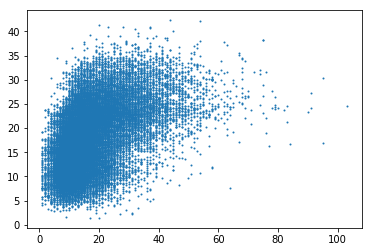

In [41]:
yy_test_xg = pd.DataFrame(columns = ['y_test', 'y_test_pred'], data = np.concatenate(
    (y_test.values.reshape(-1,1), y_test_pred_xg.reshape(-1, 1)), axis = 1))

plt.scatter(yy_test_xg['y_test'].values, yy_test_xg['y_test_pred'].values, s=1)